# Feedfoward Neural Networks & Training on GPU



## Data

In [16]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [4]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

100.1%

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [5]:
def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [23]:
batch_size=100
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size, 
                      sampler=train_sampler)

# Validation sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                    batch_size, 
                    sampler=valid_sampler)

## Using a GPU

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [18]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [65]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model

In [26]:
import torch.nn.functional as F
import torch.nn as nn

In [40]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [41]:
input_size = 784
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [42]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [46]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.283874750137329
outputs.shape :  torch.Size([100, 10])
Sample outputs :
 tensor([[-0.2803, -0.0723, -0.1015, -0.0150, -0.1574,  0.1381, -0.1888,  0.0700,
          0.0170, -0.0985],
        [-0.3539, -0.1127, -0.0333, -0.1201, -0.1200,  0.1357, -0.2533,  0.1302,
         -0.0203, -0.0746]])


## Training the Model

In [47]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate predictions
    preds = model(xb)
    # Calculate loss
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [48]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [71]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None, opt_fn=None):
    # Optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    
    #
    
    for epoch in range(epochs):
        # Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

In [72]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [101]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [95]:
evaluate(model, F.cross_entropy, valid_dl, accuracy)

(2.31587020556132, 12000, 0.09466666666666666)

In [102]:
fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.2126, accuracy: 0.9377
Epoch [2/5], Loss: 0.2069, accuracy: 0.9380
Epoch [3/5], Loss: 0.1663, accuracy: 0.9502
Epoch [4/5], Loss: 0.1443, accuracy: 0.9557
Epoch [5/5], Loss: 0.1440, accuracy: 0.9571


In [103]:
fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.1281, accuracy: 0.9633
Epoch [2/5], Loss: 0.1316, accuracy: 0.9613
Epoch [3/5], Loss: 0.1306, accuracy: 0.9627
Epoch [4/5], Loss: 0.1376, accuracy: 0.9612
Epoch [5/5], Loss: 0.1294, accuracy: 0.9642


In [92]:
import matplotlib.pyplot as plt

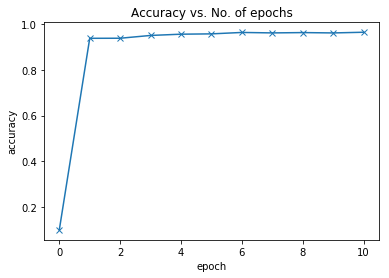

In [106]:
# Replace these values with your results
accuracies = [0.1, 0.9377, 0.9380, 0.9502, 0.9557, 0.9571, 
              0.9633, 0.9613, 0.9627, 0.9612, 0.9642]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Save and upload

In [107]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit()

[jovian] Saving notebook..


<IPython.core.display.Javascript object>